# Topic Clustering Using LDA

The purpose of this tutorial is to give you a basic understanding of Latent Dirichlet Allocation (LDA) from http://ai.stanford.edu/~ang/papers/jair03-lda.pdf and use it to implement a simple downscaled topic clustering on the newsgroup dataset from scikit-learn.

Section 1 will give some background to the mechanics and theory behind LDA. Section 2 will then tackle the task of implementing LDA to infer topics in documents based on their content. This section will provide you with skeleton code already written in Python 3 using the numpy, scipy, and scikit-learn libraries. 

If you do not have jupyter notebook installed then you probably aren't reading this, but see http://jupyter.readthedocs.io/en/latest/install.html

If you do not have a python 3 kernel installed for jupyter notebook see https://ipython.readthedocs.io/en/latest/install/kernel_install.html or https://stackoverflow.com/questions/28831854/how-do-i-add-python3-kernel-to-jupyter-ipython

If you do not have some of the libraries installed for your python 3 kernel, use the "Kernel -> Conda packages" dropdown menu in Jupyter if you used anaconda for your python 3 kernel, if not use the normal pip install commands.

## 1: Theory

### Background and terminology

Since we will be working in the setting of text corpora, we should clarify some of the terminology used in this setting:
<ul>
<li>A word is the basic unit of discrete data, defined to be an item from a vocabulary indexed by {1, . . . ,V}. 
<li> A document is a sequence of <i>N</i> words denoted by <b>w</b>=(<i>w</i><sub>1</sub>,<i>w</i><sub>2</sub>, . . . ,<i>w</i><sub>N</sub>), where <i>w</i><sub>n</sub> is the <i>n</i>th word in the sequence.</li>
<li>A corpus is a collection of <i>M</i> documents denoted by $D$ ={<b>w</b><sub>1</sub>,<b>w</b><sub>2</sub>, . . . ,<b>w</b><sub>M</sub>}</li>
</ul>

It is important to note that LDA works in other domains besides text collections, but this is the setting in which we will use it.

LDA is a generative probabilistic model that is used for modeling collections of discrete data. In our application we will be using it to model text corpora, or more specifically news group e-mails. The purpose of the model is to give us compact representations of the data in these collections, allowing us to process large collections while still retaining sufficient information to be able to perform for example classification and relevance measures. 

There have been several solutions for this type of information retrieval problem, such as the tf-idf (term frequency - inverse document frequency) scheme by Salton and McGill, 1983. This approach produces a term-by-document matrix X whose columns contain the tf-idf values for each of the documents in the corpus. This representation however did not provide significantly shortened representation of the corpora, or represent the inter- or intra- document statistics in a intuitive way. A step forward from this was given by LSI (latent semantic indexing) where singular value decomposition was used on the matrix X to offer a more compact representation. The authors of the method also argued that since the LSI features are linnear combinations of the basic tf-idf features, they incorporate some linguistical notions such as synonomy and polysemy.
The first step to providing a generative model was the <i>probabilistic</i> LSI (pLSI), which uses mixture models to model each word in a document. The mixture components are the "topics" and represented as multinomial random variables, allowing different words in the document to be genereated by different topics. The compact representation for each document is then the list of numbers representing the mixing proportions for the fixed set of topics. The method however gives no generative probabilistic model for getting these numbers, causing the number of parameters in the model to grow linearly with the corpus size. Also, since there is no probabilistic model for the mixture components that represent a document, there is no clear way of assigning a probability to a document that is outside the training set.

Both LSI and pLSI use the "bag-of-words" approach which assumes exchangeability within the words of the document as well as the documents themselves, meaning their order is of no importance. A theorem due to de Finetti (1990) states that any collection of exchangeable random variables has a representation as a mixture distribution—in general an infinite mixture. This means we must consider mixture models that capture the exchangeability of both documents and words if we wish to achieve exchangeable representations for them. It is this line of thinking that leads to LDA.




### Theory Behind LDA

As mentioned earlier, LDA is a generative probabilistic model for a corpus. It can be seen as a hierarchical Bayesian model with three levels: each document in a corpus is modeled as a finite random mixture over a latent set of topics, and each of these topics are characterized by a distribution of words. A graphical model for LDA using plate notation can be seen below:
![title](imgs/LDAPlateGM.png)
From here we can see the three levels of the model. $\alpha$ and $\beta$ and corpus level parameters, $\theta$ is a document level parameter for the M documents in the corpus, and $z$ and $w$ are word level parameters for the N words in a document.

The generative process according to LDA for each document <b>w</b> is then:
<ol>
<li>Choose N ∼Poisson(ξ)</li>
<li>Choose $\theta$∼Dir($\alpha$)</li>
<li>For each of the N words w<sub>n</sub>:
<ol type="a">
    <li>Choose a topic z<sub>n</sub> ∼Multinomial($\theta$).</li>
    <li>Choose a word w<sub>n</sub> from p(w<sub>n</sub> |z<sub>n</sub>,$\beta$), a multinomial probability conditioned on the topic z<sub>n</sub>.</li>
    </ol></li>
</ol>

There are however some simplifications to these steps that we will utilize. First, we assume that the dimensionality of the Dirichlet distribution, and therefore the dimensionality for the topic variable $z$ is known and fixed, meaning we assume a fixed known number of topics, $k$. Furthermore, the probabilities for words ($w$) are parameterized by a $k \times V$ matrix $\beta$ which defines $p(w^j = 1| z^i = 1) = \beta_{i,j}$, that we will estimate later and keep fixed. We also note that $N$ is independant of the other data generating variables $\theta$ and <b>z</b> so we will ignore the Poisson assumption and set it to a known fixed value (the length of the document).  

#### Dirichlet Distribution in LDA

The probability distribution for a $k$-dimensional Dirichlet random variable $\theta$ is defined as follows: 

<b>Eq. 1:</b>
![Eq 1](imgs/LDAEq1.png "Eq 1")


where $\alpha$ is $k$-dimensional with all elements larger than 0 and $\Gamma(x)$ is the Gamma function. The Dirichlet distribution has some advantegous advantageous qualities; it is in the exponential family, has finite dimensional sufficient statistics, and is conjugate to the multinomial distribution. These properties help us in running variational inference for the parameters later.

We can now express the joint distribution of a topic mixture $\theta$, a set of $N$ topics <b>z</b>, and
a set of $N$ words <b>w</b> given the corpus level parameters $\alpha,\beta$ as:

<b>Eq. 2:</b>
![Eq. 2](imgs/LDAEq2.png)
where the probability $p(z_n |\theta)$ is simply $\theta_i$ for the unique $i$ such that $z^i_n=1$. We can then obtain the marginal distribution over a document by integrating over $\theta$ and summing over $z$:

<b>Eq. 3:</b>
![Eq. 3](imgs/LDAEq3.png)


#### Comparison to other Latent Variable Models
In order to get feeling for how LDA works and what highlights its strengths, it can be helpful to relate it to other related models:

  a) Unigram Model

  b) Mixture of Unigrams Model

  c) pLSI Model
  


We will begin by examing the absolute simplest model, the unigram model: 

![Eq. 3](imgs/UniGramMdl.png)

This method has no latent variables and instead states that each word in a document is independantly drawn from a single multinomial distribution as seen here:

![Eq. 3](imgs/UniGramEq.png)


A slighly more complex model is the mixture of unigrams:

![Eq. 3](imgs/MixUniGramMdl.png)

This model incorporates a discrete latent topic variable, $z$. Here, each document <b>w</b> is generated by first sampling the topic variable $z$, and then generating all words from a conditional probability on that choice:

![Eq. 3](imgs/MixUniGramEq.png)

This effectively limits the modeling of words in a document to only being representative of one topic. The LDA model on the other hand allows for documents to exhibit multiple topics with different mixtures.

Finally we have the pLSI model which we mentioned earlier. It was a relatively popular model around the time that LDA was proposed, and is the model with highest generative capabilities of these three mentioned. 

![Eq. 3](imgs/PISLMdl.png)

pLSI proposes that each word is conditionally independant a "document label", $d$, given an unobserved topic $z$:

![Eq. 3](imgs/PISLEq.png)

This proposal aims to soften the constraint of having each document modeled as being generated from only one topic, as it is in the mixture of unigrams approach. It does so by incorporating the probability, $p(z | d)$ for a certain document $d$ as the mixture of topics that document. A true generative model cannot be created for this mixture however; as d is only a dummy index to the documents pISL was trained with, meaning it is a multinomial random variable with the same amount of possible values as training documents. This leads to the method only learning the topic mixtures, $p(z | d)$, for documents it has already seen, so there is no natural way to assign probability to an unseen document with it.
Another problem is that to model $k$ topics with pLSI you need K multinomial distributions with vocabulary size $V$ and $M$ mixtures over the hidden topics $k$ for each training document, resulting in $kV + kM$ parameters. Not only does this not scale well but it is also prone to overfitting.

LDA however treats the topic mixture weights as a $k$-parameter hidden variable, meaning the amount of parameters does not scale linnearly with the number training documents, and the generative model can still be used even with unseen documents.

We can see these differences geometrically as well if we examine the distribution over words as a $V$-1 dimensional on a vocabulary of size $V$ with another $k$-1 dimensional simplex spanning $k$ topics. We can set $V$ and $k$ to 3 for simplicity (3 words gives a two-dimensional triangle):

![title](imgs/UnigramSampling.png)

How this distribution is spread out and how it uses the topics distribution differs among the methods. The mixture of unigrams method pics a random point on the word simplex that corresponds to one of the topic simplex vertices k, and draws all the words for a document from the distribution corresponding to that point. pLSI assumes that all words in training documents belong to a single randomly chosen topic. The topics are drawn from a document-specific distribution, meaning each document has a topic distribution that sits on the topic simplex. The training documents then give an empirical distribution (with the marked 'x's) over the topic simplex. LDA instead models that <b>each word</b> in a document is drawn from a randomly chosen topic that is sampled from a distribution governed by a random parameter. Since this parameter is sampled once per document, it gives a smooth probability distribution over the topic simplex (the circular topology markers). 

Now that we know how LDA compares with other methods, lets take a look at how to do inference in LDA:

### Inference and Parameter Estimation with LDA

The main inference problem we will be interested in solving is the posterior distribution of the latent variables given a document, which would allow us to infer the topics associated with the document. This is given by the following equation:

\begin{equation}
p( \theta, \mathbf{z} \mid \mathbf{w}, \alpha, \beta) = \frac{p( \theta, \mathbf{z}, \mathbf{w} \mid \alpha, \beta)}{p(\mathbf{w} \mid \alpha, \beta)} 
\end{equation}

However, to compute the normalizing denominator we would rewrite equation 3 using equation 1 and $p(z_n \mid\theta)=\theta_i$ and then integrate, resulting in:

\begin{equation}
p( \mathbf{w} \mid \alpha, \beta) = \frac{\Gamma(\sum_i\alpha_i)}{\prod_i\Gamma(\alpha_i)}\int\Bigg(\prod_{i=1}^k\theta_i^{\alpha_i-1}\Bigg)\Bigg(\prod_{n=1}^N\sum_{i=1}^k\prod_{j=1}^V(\theta_i\beta_{ij})^{w_n^j}\Bigg)d\theta
\end{equation}

Unfortunately, this expression is intractable due to the coupling of $\theta$ and $\beta$ in the summation over topics. We can however solve this problem approximately using variational inference methods. 

#### Variational Inference for LDA

It is possible to use several VI methods for LDA, including La Place approximation, variational approximation, and MCMC methods. In our case, we will be using the convexity-based variational approximation that was mentioned in  Olga's tutorial. From there we learned that in this VI we attempt to reformulate/simplify the original graphical model by removing some dependencies and introducing free variational parameters. This leads to a family of distributions dependant on these variational parameters which form a lower bound on the log likelyhood. We then aim to find the parameter values that give the tightest lower bound. 

In our case, the problematic dependancy is between $\theta$ and $\beta$ which is introduced by the edges between $\theta, \mathbf{z}$ and $\mathbf{w}$ (remember w is a 'collision' node and is observed). If we simplify our model by removing these edges along with the <b>w</b> node, and introduce two variational parameters $\gamma$ and $\phi$ which give a family of distributions over the remaining latent variables, we are left with the graphical model shown on the right in the figure below:

![LDA VI](imgs/LDAVIGM.png "GM for the VI used for our LDA")

This results in the following distribution over the latent variables:

\begin{equation}
p( \theta, \mathbf{z} \mid \gamma, \phi) = q(\theta\mid\gamma)\prod_{n=1}^Nq(z_n\mid\phi_n)
\end{equation}

where the new Dirichlet parameters $\gamma$ and the multinomial parameters $\phi$ are the free variational parameters. Now having simplified our graphical model, we need to find the optimal values for the variational parameters ($\gamma^*, \phi^*$). From Olga's tutorial we know that this is equivalent to finding the values which minimize the KL divergence between the simplified distribution and the true posterior distribution:

\begin{equation}
( \gamma^*, \phi^*) = \arg\!\min_{(\gamma,\phi)}D\big(q( \theta, \mathbf{z} \mid \gamma, \phi) \mid\mid p( \theta, \mathbf{z} \mid \mathbf{w},\alpha, \beta\big)
\end{equation}

We do this by setting the derivatives of the KL divergence to zero w.r.t $\gamma$ and $\phi$ we get the following update equations for the parameters:

\begin{equation}
\phi_{ni} \propto \beta_{iw_n}\mathrm{exp}\big\lbrace\mathrm{E}_q\big[log(\theta_i)\mid\gamma\big]\big\rbrace = \beta_{iw_n}\mathrm{exp}\big\lbrace\Psi(\gamma_i)\big\rbrace
\end{equation}

\begin{equation}
\gamma_i = \alpha_i + \sum_{n=1}^N\phi_{ni}
\end{equation}

where $\Psi$ is the digamma function (first derivative of log $\Gamma$). It is important to note that these update equations derived from the KL divergence are dependant on a certain choice of <b>w</b>. This means that the shown approximation for the variational parameters is only valid for one set of words, and must therefore be calculated for each document when we use them later on. 

We must also find a way of estimating the $\beta$ matrix, as it is used in the approximations for the variational parameters. The log likelihood of the data given $\beta$ and $\alpha$ is intractable as we saw at the end of the previous section. However, it is possible to implement a variational EM procedure that gives us an approximation of the best value for $\beta$ by first maximizing a lower bound for the optimal variational parameters $\gamma^*,\phi^*$, then maximizing the lower bound w.r.t $\beta$ with the previously acquired variational parameters. Essentially we will iterate the following steps until a sufficient level of convergence:
<ol>
<li>(E-step) Find the optimizing values of the variational parameters {$\gamma^∗
_d,\phi^∗_d : d\in D$},for each document as described earlier.</li>
<li>(M-step) Maximize the resulting lower bound on the log likelihood w.r.t $\beta$ using:
\begin{equation}
\beta_{ij}\propto\sum_{d=1}^M\sum_{n=1}^{N_d}\phi^*_{dni}w^j_{dn}
\end{equation}
as well as maximize the resulting lower bound on the log likelihood w.r.t $\alpha$ (this will be given to you).
</ol>

In laymans terms, what we are essentially doing in the E-step is finding out "How prevalent are topics in the document across its words?". In the M-step we then ask "How prevalent are specific words across topics?". By using the answer from one question as a starting point for the other, we iteratively gain the answer to both. 

<span style="color:red">For proof for the update equations, see appendix of http://ai.stanford.edu/~ang/papers/jair03-lda.pdf</span>. This appendix also includes the derivation of the Newton-Raphson based method for updating $\alpha$.  

We have now seen the basic intuition behind LDA, and gone through methods for running inference based on the LDA model. In the next section we will put this knowledge in to practice.


## 2. Implementation

The goal of this task is to use LDA to create topics newsgroup documents, and infer the topic that new documents would belong to. In this setting, our document corpus is the Newsgroup dataset from scikit-learn, and a document is a certain document/e-mail. 

### Dataset

First we will load the dataset we will use for training and testing. We will simplify the example from the original paper to only do clustering for 4 topics, and only use 250 documents with a vocabulary of 750 words. While this does have an effect on the accuracy and performance of the algorithm, it's more important for you to be able to run the code in a managable amount of time. The documents I have chosen come from 4 different categories; "Christian Religion", "Hockey", "Space" and "Cars". This means that we have slightly unrealistic prior knowledge by assuming the exact correct number of topics, but don't worry there are bonus assignments in the end where you can play around with the number of topics. I have already compiled and done some preprocessing on the documents, as well as built the vocabulary dataset as pickle files. Run the code in the cell below and double check that you get the output "found 200 training and 50 test documents, with a vocabulary of 750 words". Do not worry if you get a warning regarding the version of CountVectorizer which is used for handling the vocabulary of the dataset. 

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle as pickle

vectorizer = pickle.load(open("Data/vectorizerNews.p", "rb"))
trainDocs = pickle.load(open("Data/trainDocsNews.p", "rb"))
testDocs = pickle.load(open("Data/testDocsNews.p", "rb"))

#also load the original docs that aren't pre-processed for viewing later
origTrainDocs = pickle.load(open("Data/trainDocsNewsOrig.p", "rb"))
origTestDocs = pickle.load(open("Data/testDocsNewsOrig.p", "rb"))

print("Found ", len(trainDocs), "training and ", len(testDocs), " test documents, with a vocabulary of ", len(vectorizer.get_feature_names_out()), " words.")

Found  200 training and  50  test documents, with a vocabulary of  750  words.


/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 0.18.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Parameter estimation

We must now find the optimal values for the variational parameters, as well as the values for $\alpha$ and the $\beta$ matrix that were introduced in the variational inference section. In order to follow the instructions given in the VI section we will need to do some setup first, so run the following cells:

In [2]:
#Imports
import numpy as np
import scipy.special as special
import scipy.optimize 
import time

#diGamma func from scipy, use this in your code!
diGamma = special.digamma

#Function definitions for maximizing the VI parameters. This will later be completed by you.
def maxVIParam(phi, gamma, B, alpha, M, k, Wd, eta):
    
    for d in range(M):
        N = len(Wd[d])
        #Initialization of vars, as shown in E-step. 
        phi[d] = np.ones((N,k))*1.0/k
        gamma[d] = np.ones(k)*(N/k) + alpha
        gamma_old = gamma[d]
        converged = False
        j = 0 #you can use this to print the update error to check your code in the beginning with something like:
        '''if(j%10==0 and d==0):
                    print("u e: ", updateError)'''
        #YOUR CODE FOR THE E-STEP HERE
        while not converged:
            j = j + 1
            phi[d] = B[:, Wd[d]].T * np.exp(diGamma(gamma[d]))
            phi[d] = phi[d] / np.sum(phi[d], axis=1).reshape(-1, 1)
            gamma[d] = alpha+np.sum(phi[d], axis=0)
            if np.amax(np.abs(gamma[d] - gamma_old)) < eta:
                converged = True
            gamma_old = gamma[d]
    
    return gamma, phi

#Function definitions for maximizing the B parameter. This will later be completed by you.
def MaxB(B, phi, k, V, M, Wd):
    
    #YOUR CODE FOR THE M-STEP HERE
    B = np.zeros([k, V])
    for d in range(M):
        for n in range(len(Wd[d])):
            B[:, Wd[d][n]] += phi[d][n]
    return B


In [3]:
'''Here are the functions needed for updating the alpha parameter, as shown in the start of appendix A.4.2.
These are all provided for you as it is just plugging in the definition for the gradient and hessian into the 
Newton-Raphson based method to find a stationary point using SciPy. Feel free to take a look at the appendix to
see where these values come from.'''

#value of Likelihood(gamma,phi,alpha,beta) function w.r.t. alpha terms (see start of appendix A.4.2) 
def L_alpha_val(a):
    val = 0
    M = len(gamma)
    k = len(a)
    for d in range(M):
        val += (np.log(scipy.special.gamma(np.sum(a))) - np.sum([np.log(scipy.special.gamma(a[i])) for i in range(k)]) + np.sum([((a[i] -1)*(diGamma(gamma[d][i]) - diGamma(np.sum(gamma[d])))) for i in range(k)]))

    return -val

#value of the derivative of above func w.r.t. alpha_i (2nd eq of appendix A.4.2) 
def L_alpha_der(a):
    M = len(gamma)
    k = len(a)
    der = np.array(
    [(M*(diGamma(np.sum(a)) - diGamma(a[i])) + np.sum([diGamma(gamma[d][i]) - diGamma(np.sum(gamma[d])) for d in range(M)])) for i in range(k)]
    )
    return -der

def L_alpha_hess(a):
    hess = np.zeros((len(a),len(a)))
    for i in range(len(a)):
        for j in range(len(a)):
            k_delta = 1 if i == j else 0
            hess[i,j] = k_delta*M*scipy.special.polygamma(1,a[i]) - scipy.special.polygamma(1,np.sum(a))
    return -hess

def MaxA(a):
    res = scipy.optimize.minimize(L_alpha_val, a, method='Newton-CG',
        jac=L_alpha_der, hess=L_alpha_hess,
        options={'xtol': 1e-8, 'disp': False})
    print(res.x)
    
    return res.x

With that in place, we can now initialize the required parameters and define the skeleton of our loop for the parameter estimation:

In [4]:
eta = 10e-5 #threshold for convergence

#hyperparamater init.
V = len(vectorizer.get_feature_names_out()) #vocab. cardinality
M = int(len(trainDocs)) #number of documents
k = 4 #amount of emotions

nIter=100 # number of iterations to run until parameter estimation is considered converged

#initialize B matrix as random valid distr (most common according to https://profs.sci.univr.it/~bicego/papers/2015_SIMBAD.pdf)
B = np.random.rand(k,V)

#normalize B
for i in range(k):
    B[i,:] = B[i]/np.sum(B[i])
    
alpha = np.ones(k)
#variational params (one for each doc)
phi = [None]*M
gamma = [None]*M

#word lists for all docs
Wd = [None]*M
B_values = []

'''Since scikit gives a matrix of counts of all words, and we want a list of words,
we do some quick transformations here. This gives us a representation of the documents 
as a list of numbers, where each number is the vocabulary index of a word. This way, to access
B_ij where i is the ith topic and j is the nth word in the document d, you can simply write B[i][Wd[d][n]]. If you want
replace this code a different representation for the words in a document, such as a one-hot vector for each word, you are
of course free to do so but make sure to keep track of your indexes'''

for d in range(M):
    Wmat = vectorizer.transform([trainDocs[d]]).toarray()[0] #get vocabulary matrix for document
    WVidxs = np.where(Wmat!=0)[0]
    WVcounts = Wmat[WVidxs]
    N = np.sum(WVcounts)
    W = np.zeros((N)).astype(int)

    i = 0
    for WVidx, WV in enumerate(WVidxs):
        for wordCount in range(WVcounts[WVidx]):
            W[i] = WV
            i+=1
    Wd[d] = W #We save the list of words for the document for analysis later

start = time.time()

#start of parameter estimation loop
for j in range(nIter):
    # print("on iter: ", j)
    if(j%10==0):
        print("Iteration: "+str(j)+" of "+str(nIter))
    #Variational EM for gamma and phi (E-step from VI section)
    start = time.time()
    gamma, phi = maxVIParam(phi, gamma, B, alpha, M, k, Wd, eta)
    end = time.time()
    Bold = np.copy(B)
    B = MaxB(B,phi,k,V,M,Wd) #first half of M-step from VI section 
    #renormalize B
    for i in range(k):
        B[i,:] = B[i]/np.sum(B[i])
    
    print("B max diff: ", np.amax(abs(B-Bold)))
    end = time.time()
    B_values.append(np.amax(abs(B-Bold)))
    alpha = MaxA(alpha) #second half of M-step from VI section 
    end = time.time()
    print("iter took: ", end-start)
    print("new alpha: ", alpha)
    
end = time.time()
print("took: ", end-start)

Iteration: 0 of 100
B max diff:  0.017054967377326473
[1.56985013 1.56486534 1.7246179  1.55785503]
iter took:  1.3267972469329834
new alpha:  [1.56985013 1.56486534 1.7246179  1.55785503]
B max diff:  0.006605166141303888
[1.16622021 1.2467247  1.47764565 1.26798853]
iter took:  1.0425662994384766
new alpha:  [1.16622021 1.2467247  1.47764565 1.26798853]
B max diff:  0.0049970536503406
[0.67803676 0.78196343 1.01007985 0.79753328]
iter took:  0.6657125949859619
new alpha:  [0.67803676 0.78196343 1.01007985 0.79753328]
B max diff:  0.0033670470156397653
[0.41546939 0.51148831 0.71220886 0.52581011]
iter took:  0.5886023044586182
new alpha:  [0.41546939 0.51148831 0.71220886 0.52581011]
B max diff:  0.0038816636429900176
[0.27361027 0.35712617 0.53536751 0.37365841]
iter took:  0.7993912696838379
new alpha:  [0.27361027 0.35712617 0.53536751 0.37365841]
B max diff:  0.004504022051401428
[0.19068544 0.25810069 0.42378358 0.27406191]
iter took:  0.5659096240997314
new alpha:  [0.19068544 

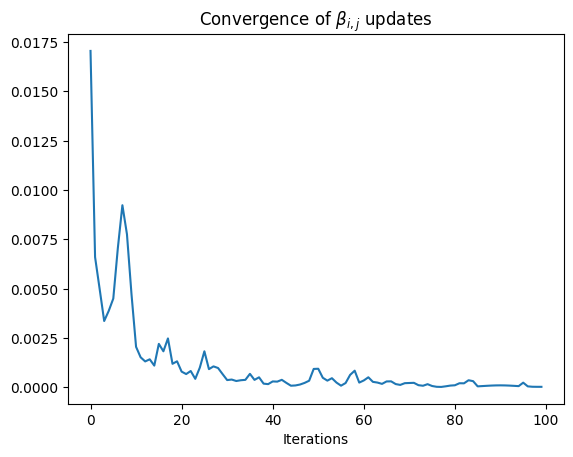

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

plt.title('Convergence of $\\beta_{i,j}$ updates')
plt.xlabel('Iterations')
plt.plot(B_values)
plt.savefig('plots/convergence')
plt.show()

#### VI Parameter Estimation
We can now begin with implementing the "E step" in the previous section which updates the variational parameters. The pseudo code for this is the following (remember these have to be calculated separately for each document):
![VIPseudo](imgs/VIPseudo.png)

Since we are working with four topics, k will be set to 4 and N will be the amount of words in the current document. Regarding the "until convergence" condition, it is sufficient to check if the largest difference between the previous and new gamma is less than $10^{-5}$. Now, use the pseudo code to fill in the missing code in the "MaxVIParam" function defined earlier and remember to use the provided diGamma function. To see that your implementation seems to be working, set nIter to 1 and add some printouts of the difference between updates for gamma, then check that they are converging to something smaller.

#### Beta Matrix Estimation
After you have implemented the MaxVIParam function, it's time to update the Beta matrix. Recall that the update function for Beta was:
\begin{equation}
\beta_{ij}\propto\sum_{d=1}^M\sum_{n=1}^{N_d}\phi^*_{dni}w^j_{dn}
\end{equation}
Implement this in the definition for MaxB above. To verify your code, you may set nIter to something low such as 10 and uncomment the "oldB" and "B max diff" lines in the code. The diff might increase at first but should start decreasing at least before iteration 10. After you have verified this, set nIter to 100 (updates should be negligable by then) and let it run unattended as it might take a couple hours. You can use the code in the following cell to save/load the parameter values you calculated for later so you don't have to re-run everything.

In [6]:
# pickle.dump(alpha, open("Data/myAlphaNews100.p", "wb"))
# pickle.dump(B, open("Data/myBetaNews100.p", "wb"))

#alpha = pickle.load(open("myAlphaNews.p", "rb"))
#B = pickle.load(open("myBetaNews.p", "rb"))

#### Verification
Let's take a look at what we've done so far. We can get an idea of what our implementation has done up to this point by inspecting the $B$ matrix. As you may remember, $B_{ij}$ holds the probability of a vocabulary word $j$ being representative of a certain topic $i$. Using the code in the following cell we can see the most representative words for our 4 topics:

In [ ]:
#representation of top words for each topic:
nTop = 20
for i in range(k):
    topVocabs = np.argsort(B[i])[-nTop:][::-1]
    topWords = np.array(vectorizer.get_feature_names_out())[topVocabs]
    print("top words for topic ",i,": ")
    print(topWords)
    data.append(topWords.T)

top words for topic  0 : 
['space' 'nasa' 'year' 'launch' 'satellite' 'use' 'father' 'mission' 'gov'
 'project' 'son' 'data' 'orbit' 'earth' 'spirit' 'research' 'program'
 'news' 'say' 'world']
top words for topic  1 : 
['god' 'say' 'people' 'jesus' 'know' 'christian' 'hell' 'believe' 'think'
 'die' 'religion' 'time' 'life' 'thing' 'question' 'faith' 'church'
 'truth' 'come' 'christ']
top words for topic  2 : 
['car' 'think' 'post' 'like' 'know' 'really' 'time' 'good' 'nntp' 'look'
 'reply' 'ca' 'say' 'use' 'distribution' 'uiuc' 'thing' 'people' 'toronto'
 'usa']
top words for topic  3 : 
['team' 'flyer' 'play' 'game' 'hockey' 'gm' 'year' 'season' 'player'
 'point' 'ca' 'goal' 'leaf' 'city' 'win' 'tie' 'record' 'nhl' 'lindros'
 'time']


#### Results:

1. Topic 0 seems pretty clear about being space science related.
2. Topic 1 is clear about being religion/christianity related.
3. Topic 2 has quite a few of words similar to topic 1, like say, think, like etc. It is not very clear from the words what is the topic. It can be due to small vocabulory/dataset.
4. Topic 3 is quite clear that it is related to sports/hockey.

Since there are no guarantees regarding the order of the topics (LDA is unsupervised) or what your initial B matrix values were, it is difficult to say exactly what results you should be seeing. Hopefully, you can see the four original topics to some extent in your result. For example, one of my topics had top words like "christ", and "god", meaning it was most likely the topic for "Christian Religion" documents, while another literally had the words "Hockey" and "NHL" in it. Our vocabulary is as mentioned earlier quite limited, so it may be possible that one of your topics is a bit unclear or close to another. You can also load the $\alpha$ and $\beta$ values in the cell below which are pre-calculated for 200 iterations and compare your topic results to those available there.

In [ ]:
alphaTest = pickle.load(open("Data/CompareAlphaNews200.p", "rb"))
BTest = pickle.load(open("Data/CompareBetaNews200.p", "rb"))
vecTest = pickle.load(open("Data/vectorizerNews.p", "rb"), encoding='latin1')

nTop = 20
for i in range(k):
    topVocabs = np.argsort(BTest[i])[-nTop:][::-1]
    topWords = np.array(vecTest.get_feature_names_out())[topVocabs]
    print("top words for topic ",i,": ")
    print(topWords)

top words for topic  0 : 
['space' 'use' 'post' 'nasa' 'nntp' 'program' 'high' '1993' 'distribution'
 'year' 'science' 'new' 'question' 'world' 'national' 'development'
 'spacecraft' 'launch' 'satellite' 'data']
top words for topic  1 : 
['god' 'people' 'say' 'know' 'christian' 'believe' 'time' 'think' 'good'
 'question' 'thing' 'christ' 'way' 'come' 'use' 'make' 'like' 'word'
 'bible' 'reason']
top words for topic  2 : 
['team' 'play' 'year' 'player' 'hockey' 'game' 'season' 'nhl' 'contact'
 'wing' 'playoff' 'red' '86' 'star' '90' '93' '92' '1992' 'point' 'blue']
top words for topic  3 : 
['think' 'post' 'know' 'car' 'time' 'say' 'like' 'nntp' 'good' 'people'
 'use' 'come' 'year' 'way' 'thing' 'really' 'look' 'make' 'work' 'usa']


/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 0.18.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


#### Results:
Upon comparison with the pre-computed topics we find similar results. Like topic 0 is about space science, topic 1 is about religion/christianity, topic 2 is about sport/hockey and topic 3 is not very clear.


#### Inferring the topic of a test document

In this section we will be using our estimated parameter values to infer the topic of some test documents. In order to do this, we will have to calculate the phi and gamma values for each new document we would like to do inference on. This is rather straight forward, and you should be able to reuse your code from the previous sections together with the test documents as a corpus instead.

In [9]:

eta = 10e-5 #threshold for convergence

#we are not re-initializing beta and alpha, we calculated them using the training docs.

V = len(vectorizer.get_feature_names_out()) #vocab. cardinality
M = int(len(testDocs)) #number of documents
k = 4 #amount of emotions

#variational params (one for each doc)
phi = [None]*M
gamma = [None]*M
WdTest = [None]*M

'''Same magic from before to get the word matrix correct, replace this if you redid this earlier.'''

for d in range(M):
    Wmat = vectorizer.transform([testDocs[d]]).toarray()[0] #get vocabulary matrix for document
    WVidxs = np.where(Wmat!=0)[0]
    WVcounts = Wmat[WVidxs]
    N = np.sum(WVcounts)
    W = np.zeros((N)).astype(int)

    i = 0
    for WVidx, WV in enumerate(WVidxs):
        for wordCount in range(WVcounts[WVidx]):
            W[i] = WV
            i+=1
    WdTest[d] = W #We save the list of words for the document for analysis later

'''Now that you have your variables initialized for the test documents, you should be able to use your previous code for 
maximizing the VI parameters with those variables instead. Remember, we're just calculating the variational parameters
gamma and phi for each test document so there is no iteration between maximizing Beta and maximizing gamma and phi.'''

# YOUR CODE to Run the gamma/phi maximization here.
gamma, phi = maxVIParam(phi, gamma, B, alpha, M, k, WdTest, eta)

We have now calculated the variational parameters for our test documents, so let us see what information we can infer from them. If you take a look at the pseudo code we used for the MaxVIParam method, you can see that the posterior gamma parameter $ \gamma_i $ we are calculating is approximately the prior Dichlet parameter $\alpha_i$ added to the expected number of words that were generated by that $ i^{th} $ topic for a certain document. Looking at the values for the different $\gamma_i$ over all words for a test document tells us what mixture of topics form such a document. Let us now take a look at the mixtures for some of our test documents by running the code in the cell below: 

In [10]:
#take a look at some example test documents (14-24 has a nice mix of topics, with a couple difficult ones)
dStart = 14
dEnd = 24
for d in range(dStart,dEnd):
    print("Estimated mixture for document ", d," is: ")
    print("_______________________")
    for i in range(len(gamma[d])):
        print("topic ", i,": ", gamma[d][i]/np.sum(gamma[d]))
    print("_______________________")
    print("Which has the following text:")
    print(" ")
    print(origTestDocs[d])
    print("__________________________________________")
    print("__________________________________________")

Estimated mixture for document  14  is: 
_______________________
topic  0 :  0.07677104863914733
topic  1 :  0.3165146094125039
topic  2 :  0.38285684338492537
topic  3 :  0.22385749856342338
_______________________
Which has the following text:
 
From: colombo@bronco.fnal.gov (Rick 'Open VMS 4ever' Colombo)
Subject: Re: Do trains/busses have radar?
Nntp-Posting-Host: bronco.fnal.gov
Organization: Fermilab Computing Division
Lines: 27

In article <C5FqFy.Fpq@usenet.ucs.indiana.edu>, mliggett@silver.ucs.indiana.edu (matthew liggett) writes:
> In <1993Apr13.111652@usho72.hou281.chevron.com> hhtra@usho72.hou281.chevron.com (T.M.Haddock) writes:
> 
> 
>> While taking an extended Easter vacation, I was going north on I-45
>> somewhere between Centerville, TX and Dallas, TX and I came upon a 
>> train parked on a trestle with its locomotive sitting directly over
>> the northbound lanes.  There appeared to be movement within the cab 
>> and out of curiosity I slowed to 85 to get a better look

#### Inference test set:

1. Document 14: It is classified as topic 2 (Car - unclear category) which seems correct because the content is not related to the other 3 categories.
2. Document 15: It is classified in topic 0 (Space science) category which is quite evident from the content of the email.
3. Document 16: It is classified in topic 1 (Religion/Christianity) category which looks correct as well.
4. Document 17: It is classified in topic 3 (Sports/Hockey), content of the email shows that it is actually about the sport.
5. Document 18: It is classified in topic 2,(Car - unclear category) again looks correct as the content is about car and automobile
6. Document 19: It is quite a comparable mixture of topic 2 & topic 3, but the content seems to be about a sports team (topic 3). This one is not quite correct.
7. Document 20: Again looks correct as a topic 1 (Religion/Christianity).

In conclusion, we were able to categorise most of the documents in their correct topics.


Revisit the cell that presented the top words for your topics. Do the presented mixtures above make sense if you look at the document content? Recall which original categories ("Religion", "Cars", "Hockey", "Space") you (to your best ability) assigned to which numbers. Do the texts seem to be discussing those topics?

<span style="color:blue">If you're re-doing this test with the MoodyLyrics dataset from the bonus section, you may be noticing some weird results. LDA can experience some issues in this setting, as for example many words that would be present in a happy song could also be present in a sad song ('love', 'hold', 'forever') but in different order or with certain "negating" words between them. It is possible to alleviate this problem by using a vocabulary of n-grams, however this increases the total size of the vocabulary (and therefore the run time as well) substantially. </span>

It is also possible to gain some more insight by examining the $\phi$ values for the documents. Recall that the $\phi$ values for the document approximate $p(z_n | \mathbf{w})$, showing how the topics are mixed for the words in the document. The cell below provides a method for printing the phi values for each word in a document. Apart from just examining how the topics are mixed for specific words, take a look at the topic mixtures for the same word that appears in several different documents. As stated in the theory section, in LDA the distribution of topic mixtures that are assigned to each word is sampled differently for each document. This means that hopefully it should be apparent from your results how the topic mixture for the same word can be differ in different test documents.

In [11]:
#14-24 gives a good mix, but try whatever you like
dStart = 14 
dEnd = 24 


def getWordsFromMatrix(WdTest):
    originalWords  = np.array(vectorizer.get_feature_names_out())[WdTest] 
    return originalWords

for dk in range(dStart,dEnd):
    
    origWords = getWordsFromMatrix(WdTest[dk])
    wordMixtures = [origWords[n] + "\t: " + str(phi[dk][n]) for n in range(len(phi[dk]))]
    for wm in set(wordMixtures):
        print(wm)
    print("________________________________")


gov	: [6.10501000e-01 3.19660317e-01 1.70726118e-36 6.98386827e-02]
think	: [0.00175373 0.34399323 0.54878044 0.1054726 ]
president	: [8.55880698e-02 4.67147714e-01 8.64945040e-80 4.47264216e-01]
box	: [3.62534544e-01 4.48710456e-01 3.09793040e-70 1.88755000e-01]
center	: [0.10847777 0.09361177 0.35320265 0.44470781]
45	: [1.50592963e-01 9.65622286e-67 2.32813908e-93 8.49407037e-01]
nntp	: [4.81862429e-02 5.61326757e-68 7.75413582e-01 1.76400175e-01]
rick	: [0.00000000e+00 2.49843562e-17 3.04843830e-01 6.95156170e-01]
strong	: [0.00000000e+00 5.87854328e-01 3.97076146e-96 4.12145672e-01]
ucs	: [3.34520430e-16 2.54468703e-01 7.45531297e-01 0.00000000e+00]
fnal	: [7.20870266e-02 9.27912973e-01 1.27788696e-33 0.00000000e+00]
look	: [3.95155204e-38 7.42845510e-02 8.15240276e-01 1.10475173e-01]
usa	: [3.24925675e-040 5.31393147e-110 8.85161732e-001 1.14838268e-001]
cause	: [1.59758151e-315 5.63659728e-001 4.36340272e-001 7.73147567e-012]
division	: [2.07411737e-002 6.67457277e-002 7.1536178

#### Bonus Objectives

Well done! You have now implemented LDA, approximated the necessary variational parameters, and examined the results to infer information about topics in documents. If you feel like you would like to experiment some more, there are some variants that you could try:

1. Load the provided dataset from the Associated Press docs dataset. This has random news articles from an undisclosed number of topics. Replace the dataset code in the beginning with what is provided in the next cell and redo your tests. What kind of topics does your result have? How many topics did you assume there were? (Some interesting cases I got were general topics like Crime and Economics and then one focusing solely on foreign affairs with President Bush)

2. Run the tests using the MoodyLyrics dataset instead. This dataset includes the lyrics from songs in many different genres (I've included has slightly less than 200 / 50 documents and V=500). Run the tests again and see what kind of sense LDA tries to make out of these song lyrics. The dataset also provides an annotation as to what emotion ("Angry", "Sad", "Happy", "Relaxed") the song exhibits. Can you find a resemblence in your topics to these emotions? (<i>Disclaimer: The lyrics provided are not censored and some are not exactly "PG-13")</i>

<b>It is possible to start to see results after ~50-60 iterations so if you would like to try out these bonus exercises you need not wait overnight</b>

In [13]:
#loading the AP docs dataset instead:
#(everything else should work like before)
vectorizer = pickle.load(open("Data/vectorizerAP.p", "rb"), encoding='latin1')
trainDocs = pickle.load(open("Data/trainDocsAP.p", "rb"), encoding='latin1')
testDocs = pickle.load(open("Data/testDocsAP.p", "rb"), encoding='latin1')


#loading the moodyLyrics dataset instead:
vectorizer = pickle.load(open("Data/vectorizerMoodyLyrics.p", "rb"), encoding='latin1')
trainLyricsFile = pickle.load(open("Data/trainDocsMoodyLyrics.p", "rb"), encoding='latin1')
testLyricsFile = pickle.load(open("Data/testDocsMoodyLyrics.p", "rb"), encoding='latin1')

trainDocs = trainLyricsFile['lyrics']
testDocs = testLyricsFile['lyrics']
#original moods can be seen with: trainGT = trainLyricsFile['groundTruth'] but the labeling is not perfect. 